# Classification for condition parametter

## Imports

In [156]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    balanced_accuracy_score
)

from scipy.stats import randint, uniform

## Read and define

In [180]:
df = pd.read_csv('../data/cleaned/data_final.csv')

# Eliminar variables claramente no predictivas de texto libre
cols_to_drop = ["url", "description", "year","new"]
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_to_drop)

# Variable objetivo
target_col = "condition"
y = df[target_col]
X = df.drop(columns=[target_col])

# Feature engineering: price_per_m2 = price / usable_area
if "price" in X.columns and "usable_area" in X.columns:
    X["price_per_m2"] = X["price"] / X["usable_area"].replace(0, np.nan)
    X["price_per_m2"] = X["price_per_m2"].fillna(X["price_per_m2"].median())

# Convertir object -> category
for col in X.select_dtypes(include="object").columns:
    X[col] = X[col].astype("category")

# Listas de variables numéricas y categóricas
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["bool", "category"]).columns.tolist()

print("Variables numéricas:", numeric_features)
print("Variables categóricas:", categorical_features)

Variables numéricas: ['price', 'built_area', 'usable_area', 'bedrooms', 'bathrooms', 'floor', 'price_per_m2']
Variables categóricas: ['zone', 'neighborhood', 'exterior', 'elevator', 'garage', 'storage_room', 'balcony', 'agency', 'consumption_label', 'emissions_label']


## Train / test split

In [158]:


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Distribución de clases en train:")
print(y_train.value_counts(normalize=True))
print("\nDistribución de clases en test:")
print(y_test.value_counts(normalize=True))

Distribución de clases en train:
condition
Buen estado    0.660224
A reformar     0.233978
Nuevo          0.105799
Name: proportion, dtype: float64

Distribución de clases en test:
condition
Buen estado    0.662602
A reformar     0.231707
Nuevo          0.105691
Name: proportion, dtype: float64


## Evaluate Model

In [159]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    macro_f1 = f1_score(y_test, y_pred, average="macro")
    mcc = matthews_corrcoef(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"\n================= {name} =================")
    print(f"Macro F1:           {macro_f1:.3f}")
    print(f"Matthews corrcoef:  {mcc:.3f}")
    print(f"Balanced accuracy:  {bal_acc:.3f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred, labels=np.unique(y_test)))


## Random Forest

In [160]:
tree_preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced"
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", tree_preprocessor),
        ("clf", rf)
    ]
)




In [161]:

# Búsqueda amplia
param_distributions_rf_wide = {
    "clf__n_estimators": randint(100, 600),
    "clf__max_depth": [None, 5, 10, 15, 20],
    "clf__min_samples_split": randint(2, 10),
    "clf__min_samples_leaf": randint(1, 5),
    "clf__max_features": ["sqrt", "log2", 0.5, 0.8],
}

rf_random_wide = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_distributions_rf_wide,
    n_iter=40,
    scoring="f1_macro",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)





print("\n>>> Entrenando Random Forest (búsqueda amplia)...")
rf_random_wide.fit(X_train, y_train)

print("Mejores hiperparámetros RF (búsqueda amplia):")
print(rf_random_wide.best_params_)
print("Mejor F1_macro (CV):", rf_random_wide.best_score_)

best_rf_params = rf_random_wide.best_params_

param_distributions_rf_refined = {
    "clf__n_estimators": randint(
        max(50, best_rf_params["clf__n_estimators"] - 100),
        best_rf_params["clf__n_estimators"] + 100
    ),
    "clf__max_depth": list({best_rf_params["clf__max_depth"], 5, 10, 15, 20, None}),
    "clf__min_samples_split": randint(2, 10),
    "clf__min_samples_leaf": randint(1, 5),
    "clf__max_features": [best_rf_params["clf__max_features"], "sqrt", "log2"],
}

rf_random_refined = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_distributions_rf_refined,
    n_iter=25,
    scoring="f1_macro",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n>>> Entrenando Random Forest (búsqueda refinada)...")
rf_random_refined.fit(X_train, y_train)

print("Mejores hiperparámetros RF (búsqueda refinada):")
print(rf_random_refined.best_params_)
print("Mejor F1_macro (CV refinada):", rf_random_refined.best_score_)

best_rf_model = rf_random_refined.best_estimator_
evaluate_model("Random Forest final", best_rf_model, X_test, y_test)


>>> Entrenando Random Forest (búsqueda amplia)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores hiperparámetros RF (búsqueda amplia):
{'clf__max_depth': None, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 234}
Mejor F1_macro (CV): 0.7805917163934544

>>> Entrenando Random Forest (búsqueda refinada)...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejores hiperparámetros RF (búsqueda refinada):
{'clf__max_depth': 15, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 9, 'clf__n_estimators': 215}
Mejor F1_macro (CV refinada): 0.7748751968974623

================= Random Forest final =================
Macro F1:           0.787
Matthews corrcoef:  0.568
Balanced accuracy:  0.793

Classification report:
              precision    recall  f1-score   support

  A reformar       0.54      0.54      0.54        57
 Buen estado       0.84      0.83      0.84       163
 

### Random forest Optimizacion con optuna

In [162]:

import optuna
import traceback

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


tree_preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


macro_f1_scorer = make_scorer(f1_score, average="macro")

def rf_objective(trial):
    #  Espacio de hiperparámetros
    n_estimators = trial.suggest_int("n_estimators", 100, 800)
    max_depth = trial.suggest_categorical("max_depth", [None, 5, 10, 15, 20, 30])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 15)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 8)
    max_features = trial.suggest_categorical(
        "max_features", ["sqrt", "log2", 0.4, 0.6, 0.8]
    )

    rf_opt = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    )

    rf_pipeline_opt = Pipeline(
        steps=[
            ("preprocess", tree_preprocessor),
            ("clf", rf_opt),
        ]
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # evitar NaNs si algún fold falla
    scores = cross_val_score(
        rf_pipeline_opt,
        X_train,
        y_train,
        cv=cv,
        scoring=macro_f1_scorer,
        n_jobs=-1,
        error_score=0.0,           # en vez de np.nan
    )

    score_mean = np.mean(scores)

    # Por seguridad absoluta, si algo raro devuelve NaN, lo pasamos a 0
    if not np.isfinite(score_mean):
        score_mean = 0.0

    return score_mean

# Crear estudio y lanzar optimización
study_rf = optuna.create_study(
    direction="maximize",
    study_name="rf_optuna_study"
)

print("\n>>> Optimizando Random Forest con Optuna...")
study_rf.optimize(rf_objective, n_trials=40, show_progress_bar=True)  # puedes subir n_trials

print("\nMejor trial RF (Optuna):")
print("  F1_macro (CV):", study_rf.best_value)
print("  Parámetros:", study_rf.best_params)

# Entrenar el modelo final con los mejores hiperparámetros
best_params = study_rf.best_params

best_rf_optuna = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)

best_rf_model = Pipeline(
    steps=[
        ("preprocess", tree_preprocessor),
        ("clf", best_rf_optuna),
    ]
)

print("\n>>> Entrenando Random Forest final con parámetros de Optuna...")
best_rf_model.fit(X_train, y_train)

evaluate_model("Random Forest (Optuna)", best_rf_model, X_test, y_test)

[I 2025-11-30 19:52:57,608] A new study created in memory with name: rf_optuna_study



>>> Optimizando Random Forest con Optuna...


Best trial: 0. Best value: 0:   2%|▎         | 1/40 [00:01<00:44,  1.15s/it]

[I 2025-11-30 19:52:58,756] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 394, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:   5%|▌         | 2/40 [00:02<00:51,  1.35s/it]

[I 2025-11-30 19:53:00,242] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 527, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:   8%|▊         | 3/40 [00:03<00:36,  1.02it/s]

[I 2025-11-30 19:53:00,779] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 151, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  10%|█         | 4/40 [00:06<01:10,  1.97s/it]

[I 2025-11-30 19:53:04,269] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 524, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 0.4}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  12%|█▎        | 5/40 [00:12<02:00,  3.43s/it]

[I 2025-11-30 19:53:10,300] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 740, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.6}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  15%|█▌        | 6/40 [00:14<01:34,  2.79s/it]

[I 2025-11-30 19:53:11,835] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 565, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  18%|█▊        | 7/40 [00:17<01:35,  2.89s/it]

[I 2025-11-30 19:53:14,921] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 409, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.8}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  20%|██        | 8/40 [00:20<01:37,  3.03s/it]

[I 2025-11-30 19:53:18,268] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 703, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 0.8}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  22%|██▎       | 9/40 [00:24<01:39,  3.20s/it]

[I 2025-11-30 19:53:21,837] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 488, 'max_depth': None, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 0.8}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  25%|██▌       | 10/40 [00:28<01:42,  3.42s/it]

[I 2025-11-30 19:53:25,744] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 700, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 0.4}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  28%|██▊       | 11/40 [00:29<01:16,  2.65s/it]

[I 2025-11-30 19:53:26,659] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 304, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  30%|███       | 12/40 [00:29<00:59,  2.13s/it]

[I 2025-11-30 19:53:27,593] Trial 11 finished with value: 0.0 and parameters: {'n_estimators': 334, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  32%|███▎      | 13/40 [00:30<00:44,  1.66s/it]

[I 2025-11-30 19:53:28,159] Trial 12 finished with value: 0.0 and parameters: {'n_estimators': 188, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  35%|███▌      | 14/40 [00:32<00:42,  1.64s/it]

[I 2025-11-30 19:53:29,749] Trial 13 finished with value: 0.0 and parameters: {'n_estimators': 564, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  38%|███▊      | 15/40 [00:34<00:47,  1.88s/it]

[I 2025-11-30 19:53:32,196] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 364, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.6}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  40%|████      | 16/40 [00:35<00:38,  1.62s/it]

[I 2025-11-30 19:53:33,198] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 266, 'max_depth': None, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  42%|████▎     | 17/40 [00:36<00:34,  1.51s/it]

[I 2025-11-30 19:53:34,452] Trial 16 finished with value: 0.0 and parameters: {'n_estimators': 444, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  45%|████▌     | 18/40 [00:38<00:35,  1.62s/it]

[I 2025-11-30 19:53:36,322] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 643, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  48%|████▊     | 19/40 [00:39<00:27,  1.33s/it]

[I 2025-11-30 19:53:36,986] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 221, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  50%|█████     | 20/40 [00:43<00:43,  2.19s/it]

[I 2025-11-30 19:53:41,169] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 645, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 0.6}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  52%|█████▎    | 21/40 [00:44<00:36,  1.92s/it]

[I 2025-11-30 19:53:42,471] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 417, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  55%|█████▌    | 22/40 [00:45<00:26,  1.48s/it]

[I 2025-11-30 19:53:42,935] Trial 21 finished with value: 0.0 and parameters: {'n_estimators': 144, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  57%|█████▊    | 23/40 [00:45<00:20,  1.21s/it]

[I 2025-11-30 19:53:43,514] Trial 22 finished with value: 0.0 and parameters: {'n_estimators': 147, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  60%|██████    | 24/40 [00:46<00:15,  1.05it/s]

[I 2025-11-30 19:53:43,867] Trial 23 finished with value: 0.0 and parameters: {'n_estimators': 108, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  62%|██████▎   | 25/40 [00:49<00:23,  1.56s/it]

[I 2025-11-30 19:53:46,846] Trial 24 finished with value: 0.0 and parameters: {'n_estimators': 800, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.4}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  65%|██████▌   | 26/40 [00:50<00:21,  1.52s/it]

[I 2025-11-30 19:53:48,252] Trial 25 finished with value: 0.0 and parameters: {'n_estimators': 486, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  68%|██████▊   | 27/40 [00:51<00:17,  1.38s/it]

[I 2025-11-30 19:53:49,315] Trial 26 finished with value: 0.0 and parameters: {'n_estimators': 377, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  70%|███████   | 28/40 [00:52<00:14,  1.22s/it]

[I 2025-11-30 19:53:50,169] Trial 27 finished with value: 0.0 and parameters: {'n_estimators': 261, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  72%|███████▎  | 29/40 [00:54<00:14,  1.32s/it]

[I 2025-11-30 19:53:51,707] Trial 28 finished with value: 0.0 and parameters: {'n_estimators': 573, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  75%|███████▌  | 30/40 [00:57<00:19,  1.94s/it]

[I 2025-11-30 19:53:55,113] Trial 29 finished with value: 0.0 and parameters: {'n_estimators': 512, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 0.4}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  78%|███████▊  | 31/40 [00:59<00:17,  1.95s/it]

[I 2025-11-30 19:53:57,084] Trial 30 finished with value: 0.0 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 0.6}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  80%|████████  | 32/40 [01:03<00:20,  2.54s/it]

[I 2025-11-30 19:54:00,999] Trial 31 finished with value: 0.0 and parameters: {'n_estimators': 596, 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 0.4}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  82%|████████▎ | 33/40 [01:06<00:18,  2.66s/it]

[I 2025-11-30 19:54:03,922] Trial 32 finished with value: 0.0 and parameters: {'n_estimators': 531, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 0.4}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  85%|████████▌ | 34/40 [01:10<00:18,  3.12s/it]

[I 2025-11-30 19:54:08,112] Trial 33 finished with value: 0.0 and parameters: {'n_estimators': 612, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 0.4}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  88%|████████▊ | 35/40 [01:14<00:16,  3.25s/it]

[I 2025-11-30 19:54:11,659] Trial 34 finished with value: 0.0 and parameters: {'n_estimators': 425, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 0.8}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  90%|█████████ | 36/40 [01:16<00:12,  3.14s/it]

[I 2025-11-30 19:54:14,567] Trial 35 finished with value: 0.0 and parameters: {'n_estimators': 478, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.4}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  92%|█████████▎| 37/40 [01:20<00:10,  3.34s/it]

[I 2025-11-30 19:54:18,365] Trial 36 finished with value: 0.0 and parameters: {'n_estimators': 521, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.8}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  95%|█████████▌| 38/40 [01:22<00:05,  2.92s/it]

[I 2025-11-30 19:54:20,300] Trial 37 finished with value: 0.0 and parameters: {'n_estimators': 675, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  98%|█████████▊| 39/40 [01:23<00:02,  2.37s/it]

[I 2025-11-30 19:54:21,402] Trial 38 finished with value: 0.0 and parameters: {'n_estimators': 376, 'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0: 100%|██████████| 40/40 [01:28<00:00,  2.21s/it]


[I 2025-11-30 19:54:26,019] Trial 39 finished with value: 0.0 and parameters: {'n_estimators': 764, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 0.6}. Best is trial 0 with value: 0.0.

Mejor trial RF (Optuna):
  F1_macro (CV): 0.0
  Parámetros: {'n_estimators': 394, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2'}

>>> Entrenando Random Forest final con parámetros de Optuna...

================= Random Forest (Optuna) =================
Macro F1:           0.725
Matthews corrcoef:  0.478
Balanced accuracy:  0.766

Classification report:
              precision    recall  f1-score   support

  A reformar       0.45      0.58      0.51        57
 Buen estado       0.83      0.72      0.77       163
       Nuevo       0.81      1.00      0.90        26

    accuracy                           0.72       246
   macro avg       0.70      0.77      0.72       246
weighted avg       0.74      0.72      0.72       246

Co

## Naive Bayes

In [163]:
nb_preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# GaussianNB no acepta sparse  convertimos a denso
to_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)




In [164]:
nb_pipeline = Pipeline(
    steps=[
        ("preprocess", nb_preprocessor),
        ("to_dense", to_dense),
        ("clf", GaussianNB())
    ]
)

print("\n>>> Entrenando Naive Bayes...")
nb_pipeline.fit(X_train, y_train)
evaluate_model("Naive Bayes (GaussianNB)", nb_pipeline, X_test, y_test)


>>> Entrenando Naive Bayes...

================= Naive Bayes (GaussianNB) =================
Macro F1:           0.691
Matthews corrcoef:  0.438
Balanced accuracy:  0.759

Classification report:
              precision    recall  f1-score   support

  A reformar       0.34      0.84      0.49        57
 Buen estado       0.89      0.44      0.58       163
       Nuevo       1.00      1.00      1.00        26

    accuracy                           0.59       246
   macro avg       0.74      0.76      0.69       246
weighted avg       0.77      0.59      0.61       246

Confusion matrix:
[[48  9  0]
 [92 71  0]
 [ 0  0 26]]


### Naive bayes Optimizacion con optuna

In [165]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
import optuna
import numpy as np

macro_f1_scorer = make_scorer(f1_score, average="macro")

def nb_objective(trial):
    # Hiperparámetro principal de GaussianNB
    var_smoothing = trial.suggest_float(
        "var_smoothing",
        1e-12,
        1e-6,
        log=True  # búsqueda logarítmica
    )

    nb_clf = GaussianNB(var_smoothing=var_smoothing)

    nb_pipeline_opt = Pipeline(
        steps=[
            ("preprocess", nb_preprocessor),
            ("to_dense", to_dense),
            ("clf", nb_clf),
        ]
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(
        nb_pipeline_opt,
        X_train,
        y_train,
        cv=cv,
        scoring=macro_f1_scorer,
        n_jobs=-1,
        error_score=0.0,   # 👈 importante para evitar NaN si algún fold falla
    )

    score_mean = np.mean(scores)
    if not np.isfinite(score_mean):
        score_mean = 0.0

    return score_mean


from optuna.trial import TrialState

study_nb = optuna.create_study(
    direction="maximize",
    study_name="nb_optuna_study"
)

print("\n>>> Optimizando Naive Bayes (GaussianNB) con Optuna...")
study_nb.optimize(nb_objective, n_trials=30, show_progress_bar=True)

completed_trials_nb = [t for t in study_nb.trials if t.state == TrialState.COMPLETE]

if len(completed_trials_nb) == 0:
    print("\n[AVISO] Optuna no ha podido completar ningún trial para Naive Bayes.")
    print("Se mantiene la versión básica del modelo sin optimización.")
    # Versión simple por si acaso
    nb_pipeline = Pipeline(
        steps=[
            ("preprocess", nb_preprocessor),
            ("to_dense", to_dense),
            ("clf", GaussianNB())
        ]
    )
else:
    print("\nMejor trial NB (Optuna):")
    print("  F1_macro (CV):", study_nb.best_value)
    print("  Parámetros:", study_nb.best_params)

    best_nb_params = study_nb.best_params

    best_nb_clf = GaussianNB(
        var_smoothing=best_nb_params["var_smoothing"]
    )

    nb_pipeline = Pipeline(
        steps=[
            ("preprocess", nb_preprocessor),
            ("to_dense", to_dense),
            ("clf", best_nb_clf)
        ]
    )

print("\n>>> Entrenando Naive Bayes (GaussianNB) final...")
nb_pipeline.fit(X_train, y_train)
evaluate_model("Naive Bayes (GaussianNB, Optuna)", nb_pipeline, X_test, y_test)


[I 2025-11-30 19:54:27,484] A new study created in memory with name: nb_optuna_study



>>> Optimizando Naive Bayes (GaussianNB) con Optuna...


Best trial: 0. Best value: 0:   7%|▋         | 2/30 [00:00<00:02, 12.90it/s]

[I 2025-11-30 19:54:27,569] Trial 0 finished with value: 0.0 and parameters: {'var_smoothing': 2.314845571615556e-10}. Best is trial 0 with value: 0.0.
[I 2025-11-30 19:54:27,638] Trial 1 finished with value: 0.0 and parameters: {'var_smoothing': 1.2051370648141936e-09}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:   7%|▋         | 2/30 [00:00<00:02, 12.90it/s]

[I 2025-11-30 19:54:27,710] Trial 2 finished with value: 0.0 and parameters: {'var_smoothing': 5.801248334811592e-07}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  13%|█▎        | 4/30 [00:00<00:01, 13.47it/s]

[I 2025-11-30 19:54:27,783] Trial 3 finished with value: 0.0 and parameters: {'var_smoothing': 1.907069003640744e-09}. Best is trial 0 with value: 0.0.
[I 2025-11-30 19:54:27,864] Trial 4 finished with value: 0.0 and parameters: {'var_smoothing': 1.7067817209565593e-12}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  20%|██        | 6/30 [00:00<00:01, 13.00it/s]

[I 2025-11-30 19:54:27,942] Trial 5 finished with value: 0.0 and parameters: {'var_smoothing': 4.5587665047673266e-12}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  27%|██▋       | 8/30 [00:00<00:01, 13.49it/s]

[I 2025-11-30 19:54:28,010] Trial 6 finished with value: 0.0 and parameters: {'var_smoothing': 1.6127257946432442e-10}. Best is trial 0 with value: 0.0.
[I 2025-11-30 19:54:28,081] Trial 7 finished with value: 0.0 and parameters: {'var_smoothing': 1.0840646437317206e-11}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  27%|██▋       | 8/30 [00:00<00:01, 13.49it/s]

[I 2025-11-30 19:54:28,152] Trial 8 finished with value: 0.0 and parameters: {'var_smoothing': 2.777745002534875e-10}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  33%|███▎      | 10/30 [00:00<00:01, 13.78it/s]

[I 2025-11-30 19:54:28,222] Trial 9 finished with value: 0.0 and parameters: {'var_smoothing': 9.559646897035015e-09}. Best is trial 0 with value: 0.0.
[I 2025-11-30 19:54:28,296] Trial 10 finished with value: 0.0 and parameters: {'var_smoothing': 1.5223788085953137e-07}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  40%|████      | 12/30 [00:00<00:01, 13.72it/s]

[I 2025-11-30 19:54:28,368] Trial 11 finished with value: 0.0 and parameters: {'var_smoothing': 4.848015471559139e-11}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  47%|████▋     | 14/30 [00:01<00:01, 13.67it/s]

[I 2025-11-30 19:54:28,442] Trial 12 finished with value: 0.0 and parameters: {'var_smoothing': 6.393492546557179e-09}. Best is trial 0 with value: 0.0.
[I 2025-11-30 19:54:28,516] Trial 13 finished with value: 0.0 and parameters: {'var_smoothing': 2.076699771187912e-08}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  47%|████▋     | 14/30 [00:01<00:01, 13.67it/s]

[I 2025-11-30 19:54:28,590] Trial 14 finished with value: 0.0 and parameters: {'var_smoothing': 1.021210838721264e-09}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  53%|█████▎    | 16/30 [00:01<00:01, 13.75it/s]

[I 2025-11-30 19:54:28,659] Trial 15 finished with value: 0.0 and parameters: {'var_smoothing': 4.040655909004597e-11}. Best is trial 0 with value: 0.0.
[I 2025-11-30 19:54:28,734] Trial 16 finished with value: 0.0 and parameters: {'var_smoothing': 2.815279676240913e-10}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  60%|██████    | 18/30 [00:01<00:00, 13.63it/s]

[I 2025-11-30 19:54:28,808] Trial 17 finished with value: 0.0 and parameters: {'var_smoothing': 4.822755307724506e-08}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  67%|██████▋   | 20/30 [00:01<00:00, 13.33it/s]

[I 2025-11-30 19:54:28,890] Trial 18 finished with value: 0.0 and parameters: {'var_smoothing': 1.8309065074851497e-09}. Best is trial 0 with value: 0.0.
[I 2025-11-30 19:54:28,967] Trial 19 finished with value: 0.0 and parameters: {'var_smoothing': 5.8021438104856995e-11}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  67%|██████▋   | 20/30 [00:01<00:00, 13.33it/s]

[I 2025-11-30 19:54:29,042] Trial 20 finished with value: 0.0 and parameters: {'var_smoothing': 3.5900265331750996e-09}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  73%|███████▎  | 22/30 [00:01<00:00, 13.33it/s]

[I 2025-11-30 19:54:29,116] Trial 21 finished with value: 0.0 and parameters: {'var_smoothing': 8.462634523113756e-07}. Best is trial 0 with value: 0.0.
[I 2025-11-30 19:54:29,190] Trial 22 finished with value: 0.0 and parameters: {'var_smoothing': 9.215549695980754e-07}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  80%|████████  | 24/30 [00:01<00:00, 13.39it/s]

[I 2025-11-30 19:54:29,264] Trial 23 finished with value: 0.0 and parameters: {'var_smoothing': 8.022939467215704e-08}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  87%|████████▋ | 26/30 [00:01<00:00, 13.45it/s]

[I 2025-11-30 19:54:29,337] Trial 24 finished with value: 0.0 and parameters: {'var_smoothing': 2.378643581885566e-07}. Best is trial 0 with value: 0.0.
[I 2025-11-30 19:54:29,411] Trial 25 finished with value: 0.0 and parameters: {'var_smoothing': 4.318574184286234e-10}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  87%|████████▋ | 26/30 [00:02<00:00, 13.45it/s]

[I 2025-11-30 19:54:29,488] Trial 26 finished with value: 0.0 and parameters: {'var_smoothing': 1.939556552855957e-11}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  93%|█████████▎| 28/30 [00:02<00:00, 13.41it/s]

[I 2025-11-30 19:54:29,562] Trial 27 finished with value: 0.0 and parameters: {'var_smoothing': 1.9688013395643714e-08}. Best is trial 0 with value: 0.0.
[I 2025-11-30 19:54:29,635] Trial 28 finished with value: 0.0 and parameters: {'var_smoothing': 6.546212674343675e-10}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0: 100%|██████████| 30/30 [00:02<00:00, 13.48it/s]


[I 2025-11-30 19:54:29,705] Trial 29 finished with value: 0.0 and parameters: {'var_smoothing': 1.2594540657969708e-10}. Best is trial 0 with value: 0.0.

Mejor trial NB (Optuna):
  F1_macro (CV): 0.0
  Parámetros: {'var_smoothing': 2.314845571615556e-10}

>>> Entrenando Naive Bayes (GaussianNB) final...

================= Naive Bayes (GaussianNB, Optuna) =================
Macro F1:           0.691
Matthews corrcoef:  0.438
Balanced accuracy:  0.759

Classification report:
              precision    recall  f1-score   support

  A reformar       0.34      0.84      0.49        57
 Buen estado       0.89      0.44      0.58       163
       Nuevo       1.00      1.00      1.00        26

    accuracy                           0.59       246
   macro avg       0.74      0.76      0.69       246
weighted avg       0.77      0.59      0.61       246

Confusion matrix:
[[48  9  0]
 [92 71  0]
 [ 0  0 26]]


## SVM

### SVM sin pca

In [166]:

svm_preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)

from sklearn.svm import SVC

svm_base = Pipeline(
    steps=[
        ("preprocess", svm_preprocessor),
        ("scaler", StandardScaler()),
        ("clf", SVC(
            kernel="rbf",
            class_weight="balanced",
            probability=True    
        ))
    ]
)

from scipy.stats import uniform

param_distributions_svm = {
    "clf__C": uniform(0.1, 10.0),
    "clf__gamma": uniform(0.001, 0.5)
}

svm_random = RandomizedSearchCV(
    estimator=svm_base,
    param_distributions=param_distributions_svm,
    n_iter=30,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n>>> Entrenando SVM (SIN PCA) con RandomizedSearch...")
svm_random.fit(X_train, y_train)

print("Mejores hiperparámetros SVM (sin PCA):")
print(svm_random.best_params_)
print("Mejor F1_macro (CV):", svm_random.best_score_)

best_svm_model = svm_random.best_estimator_
evaluate_model("SVM (sin PCA)", best_svm_model, X_test, y_test)


>>> Entrenando SVM (SIN PCA) con RandomizedSearch...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Mejores hiperparámetros SVM (sin PCA):
{'clf__C': 6.0241456886204245, 'clf__gamma': 0.024225206359998863}
Mejor F1_macro (CV): 0.6649854103091566

================= SVM (sin PCA) =================
Macro F1:           0.674
Matthews corrcoef:  0.430
Balanced accuracy:  0.683

Classification report:
              precision    recall  f1-score   support

  A reformar       0.35      0.14      0.20        57
 Buen estado       0.75      0.91      0.82       163
       Nuevo       1.00      1.00      1.00        26

    accuracy                           0.74       246
   macro avg       0.70      0.68      0.67       246
weighted avg       0.68      0.74      0.70       246

Confusion matrix:
[[  8  49   0]
 [ 15 148   0]
 [  0   0  26]]


## Decision Tree

In [167]:
dt_clf = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

dt_pipeline = Pipeline(
    steps=[
        ("preprocess", tree_preprocessor),
        ("clf", dt_clf)
    ]
)

print("\n>>> Entrenando Árbol de decisión (parámetros por defecto)...")
dt_pipeline.fit(X_train, y_train)
evaluate_model("Árbol de decisión", dt_pipeline, X_test, y_test)



>>> Entrenando Árbol de decisión (parámetros por defecto)...

================= Árbol de decisión =================
Macro F1:           0.748
Matthews corrcoef:  0.480
Balanced accuracy:  0.759

Classification report:
              precision    recall  f1-score   support

  A reformar       0.44      0.51      0.47        57
 Buen estado       0.82      0.77      0.79       163
       Nuevo       0.96      1.00      0.98        26

    accuracy                           0.73       246
   macro avg       0.74      0.76      0.75       246
weighted avg       0.74      0.73      0.74       246

Confusion matrix:
[[ 29  28   0]
 [ 37 125   1]
 [  0   0  26]]


## Logistic regression

In [168]:
logreg_preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)

logreg_pipeline = Pipeline(
    steps=[
        ("preprocess", logreg_preprocessor),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            multi_class="multinomial",
            class_weight="balanced",
            max_iter=1000,
            n_jobs=-1
        ))
    ]
)

print("\n>>> Entrenando Regresión Logística multinomial...")
logreg_pipeline.fit(X_train, y_train)
evaluate_model("Regresión Logística (multinomial)", logreg_pipeline, X_test, y_test)



>>> Entrenando Regresión Logística multinomial...


C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



================= Regresión Logística (multinomial) =================
Macro F1:           0.733
Matthews corrcoef:  0.448
Balanced accuracy:  0.743

Classification report:
              precision    recall  f1-score   support

  A reformar       0.41      0.47      0.44        57
 Buen estado       0.80      0.75      0.78       163
       Nuevo       0.96      1.00      0.98        26

    accuracy                           0.72       246
   macro avg       0.73      0.74      0.73       246
weighted avg       0.73      0.72      0.72       246

Confusion matrix:
[[ 27  30   0]
 [ 39 123   1]
 [  0   0  26]]


## k-NN

In [169]:
knn_preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)

knn_base = Pipeline(
    steps=[
        ("preprocess", knn_preprocessor),
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier())
    ]
)

param_distributions_knn = {
    "clf__n_neighbors": randint(3, 30),
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]  # Manhattan vs Euclídea
}

knn_random = RandomizedSearchCV(
    estimator=knn_base,
    param_distributions=param_distributions_knn,
    n_iter=20,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n>>> Entrenando k-NN con RandomizedSearch...")
knn_random.fit(X_train, y_train)

print("Mejores hiperparámetros k-NN:")
print(knn_random.best_params_)
print("Mejor F1_macro (CV):", knn_random.best_score_)

best_knn_model = knn_random.best_estimator_
evaluate_model("k-NN (mejor modelo)", best_knn_model, X_test, y_test)



>>> Entrenando k-NN con RandomizedSearch...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros k-NN:
{'clf__n_neighbors': 6, 'clf__p': 2, 'clf__weights': 'distance'}
Mejor F1_macro (CV): 0.6801600782619172

================= k-NN (mejor modelo) =================
Macro F1:           0.675
Matthews corrcoef:  0.434
Balanced accuracy:  0.696

Classification report:
              precision    recall  f1-score   support

  A reformar       0.41      0.21      0.28        57
 Buen estado       0.76      0.88      0.82       163
       Nuevo       0.87      1.00      0.93        26

    accuracy                           0.74       246
   macro avg       0.68      0.70      0.67       246
weighted avg       0.69      0.74      0.70       246

Confusion matrix:
[[ 12  44   1]
 [ 17 143   3]
 [  0   0  26]]


C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.60633611 0.65657757 0.64337317        nan 0.58476586 0.68016008
 0.64032971 0.67590586 0.65998699 0.64337317 0.55251515        nan
        nan 0.63938361 0.65361065 0.5570373  0.65893153        nan
        nan 0.67169558]
  warnings.warn(


## GRADIENT BOOSTING

In [170]:
gb_preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

gb_clf = GradientBoostingClassifier(random_state=42)

gb_pipeline = Pipeline(
    steps=[
        ("preprocess", gb_preprocessor),
        ("clf", gb_clf)
    ]
)

print("\n>>> Entrenando Gradient Boosting (parámetros por defecto)...")
gb_pipeline.fit(X_train, y_train)
evaluate_model("Gradient Boosting", gb_pipeline, X_test, y_test)





>>> Entrenando Gradient Boosting (parámetros por defecto)...

================= Gradient Boosting =================
Macro F1:           0.737
Matthews corrcoef:  0.522
Balanced accuracy:  0.735

Classification report:
              precision    recall  f1-score   support

  A reformar       0.55      0.30      0.39        57
 Buen estado       0.79      0.91      0.84       163
       Nuevo       0.96      1.00      0.98        26

    accuracy                           0.78       246
   macro avg       0.77      0.74      0.74       246
weighted avg       0.75      0.78      0.75       246

Confusion matrix:
[[ 17  40   0]
 [ 14 148   1]
 [  0   0  26]]


## Voting Classifier

Utilizando la idea de random forest hacer un clasificador con el que tenga el mejor resultado entre todos los clasificadores

In [171]:
from sklearn.ensemble import VotingClassifier

voting_soft = VotingClassifier(
    estimators=[
        ("rf", best_rf_model),
        ("logreg", logreg_pipeline),
    ],
    voting="soft",        
    weights=[2, 1]        # RF  mas peso que LR
)

print("\n>>> Entrenando VotingClassifier (RF + LR, soft voting)...")
voting_soft.fit(X_train, y_train)

evaluate_model("VotingClassifier (RF + LR, soft)", voting_soft, X_test, y_test)


>>> Entrenando VotingClassifier (RF + LR, soft voting)...


C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



================= VotingClassifier (RF + LR, soft) =================
Macro F1:           0.743
Matthews corrcoef:  0.468
Balanced accuracy:  0.754

Classification report:
              precision    recall  f1-score   support

  A reformar       0.43      0.51      0.46        57
 Buen estado       0.81      0.75      0.78       163
       Nuevo       0.96      1.00      0.98        26

    accuracy                           0.72       246
   macro avg       0.73      0.75      0.74       246
weighted avg       0.74      0.72      0.73       246

Confusion matrix:
[[ 29  28   0]
 [ 39 123   1]
 [  0   0  26]]


In [172]:
from sklearn.ensemble import VotingClassifier

voting_soft_all = VotingClassifier(
    estimators=[
        ("rf", best_rf_model),      # Random Forest (pipeline ya con preprocesado)
        ("dt", dt_pipeline),        # Árbol de decisión (pipeline)
        ("logreg", logreg_pipeline),# Regresión logística (pipeline)
        ("knn", best_knn_model),    # k-NN (pipeline)
        ("nb", nb_pipeline),        # Naive Bayes (pipeline con to_dense)
        ("gb", gb_pipeline),        # Gradient Boosting (pipeline)
    ],
    voting="soft",                 # promediamos probabilidades
    weights=[2, 1, 1, 1, 1, 2]
)

print("\n>>> Entrenando VotingClassifier (RF + DT + LR + kNN + NB + GB, soft voting, sin SVM)...")
voting_soft_all.fit(X_train, y_train)

evaluate_model("VotingClassifier (soft, sin SVM)", voting_soft_all, X_test, y_test)


>>> Entrenando VotingClassifier (RF + DT + LR + kNN + NB + GB, soft voting, sin SVM)...


C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



================= VotingClassifier (soft, sin SVM) =================
Macro F1:           0.791
Matthews corrcoef:  0.578
Balanced accuracy:  0.793

Classification report:
              precision    recall  f1-score   support

  A reformar       0.57      0.53      0.55        57
 Buen estado       0.84      0.85      0.84       163
       Nuevo       0.96      1.00      0.98        26

    accuracy                           0.79       246
   macro avg       0.79      0.79      0.79       246
weighted avg       0.79      0.79      0.79       246

Confusion matrix:
[[ 30  27   0]
 [ 23 139   1]
 [  0   0  26]]


## xgboost

In [181]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Codificamos las etiquetas y en enteros solo para XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # y_train -> 0,1,2
y_test_enc = le.transform(y_test)         # y_test -> 0,1,2

# Usamos el mismo preprocesador de RF (tree_preprocessor: num + OneHot)
xgb_clf = XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    learning_rate=0.1,
    n_estimators=300,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42
)

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", tree_preprocessor),  # el mismo que usas en RF
        ("clf", xgb_clf)
    ]
)

print("\n>>> Entrenando XGBoost (ejemplo simple)...")
xgb_pipeline.fit(X_train, y_train_enc)

# Predicciones codificadas (0,1,2)
y_pred_enc = xgb_pipeline.predict(X_test)

# Volvemos a las etiquetas originales ('A reformar', 'Buen estado', 'Nuevo')
y_pred = le.inverse_transform(y_pred_enc)

# Evaluamos con las etiquetas originales para ser coherentes con el resto
print("\n================= XGBoost (ejemplo) =================")
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred, labels=np.unique(y_test)))


>>> Entrenando XGBoost (ejemplo simple)...

================= XGBoost (ejemplo) =================
Macro F1: 0.7569657155511242

Classification report:
              precision    recall  f1-score   support

  A reformar       0.52      0.40      0.46        57
 Buen estado       0.81      0.87      0.83       163
       Nuevo       0.96      1.00      0.98        26

    accuracy                           0.77       246
   macro avg       0.76      0.76      0.76       246
weighted avg       0.76      0.77      0.76       246

Confusion matrix:
[[ 23  34   0]
 [ 21 141   1]
 [  0   0  26]]


### Optuna peores resultados

In [182]:
import optuna
import numpy as np

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix


macro_f1_scorer = make_scorer(f1_score, average="macro")


def xgb_objective(trial):
    # Espacio de hiperparámetros a explorar
    n_estimators = trial.suggest_int("n_estimators", 200, 800)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    subsample = trial.suggest_float("subsample", 0.6, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 8)
    gamma = trial.suggest_float("gamma", 0.0, 0.5)

    xgb_clf = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        num_class=3,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        gamma=gamma,
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
    )

    xgb_pipeline_opt = Pipeline(
        steps=[
            ("preprocess", tree_preprocessor),  # num + OneHot
            ("clf", xgb_clf),
        ]
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(
        xgb_pipeline_opt,
        X_train,
        y_train_enc,   # y codificada
        cv=cv,
        scoring=macro_f1_scorer,
        n_jobs=-1,
        error_score=0.0,
    )

    score_mean = np.mean(scores)
    if not np.isfinite(score_mean):
        score_mean = 0.0

    return score_mean



from optuna.trial import TrialState

study_xgb = optuna.create_study(
    direction="maximize",
    study_name="xgb_optuna_study"
)

print("\n>>> Optimizando XGBoost con Optuna...")
study_xgb.optimize(xgb_objective, n_trials=40, show_progress_bar=True)

completed_trials_xgb = [t for t in study_xgb.trials if t.state == TrialState.COMPLETE]

if len(completed_trials_xgb) == 0:
    print("\n[AVISO] Optuna no ha podido completar ningún trial para XGBoost.")
    print("Se mantiene la versión simple (ejemplo) que ya tenías.")
    # Aquí podrías seguir usando tu xgb_pipeline actual.
else:
    print("\nMejor trial XGBoost (Optuna):")
    print("  F1_macro (CV):", study_xgb.best_value)
    print("  Parámetros:", study_xgb.best_params)

    bp = study_xgb.best_params

    best_xgb_clf = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        num_class=3,
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        n_estimators=bp["n_estimators"],
        max_depth=bp["max_depth"],
        learning_rate=bp["learning_rate"],
        subsample=bp["subsample"],
        colsample_bytree=bp["colsample_bytree"],
        min_child_weight=bp["min_child_weight"],
        gamma=bp["gamma"],
    )

    best_xgb_pipeline = Pipeline(
        steps=[
            ("preprocess", tree_preprocessor),
            ("clf", best_xgb_clf),
        ]
    )

    print("\n>>> Entrenando XGBoost final (Optuna)...")
    best_xgb_pipeline.fit(X_train, y_train_enc)

    # Predicción en test y deshacer la codificación
    y_pred_enc = best_xgb_pipeline.predict(X_test)
    y_pred = le.inverse_transform(y_pred_enc)

    print("\n================= XGBoost (Optuna) =================")
    print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred, labels=np.unique(y_test)))


[I 2025-11-30 19:58:37,412] A new study created in memory with name: xgb_optuna_study



>>> Optimizando XGBoost con Optuna...


Best trial: 0. Best value: 0.731993:   2%|▎         | 1/40 [00:00<00:36,  1.07it/s]

[I 2025-11-30 19:58:38,346] Trial 0 finished with value: 0.7319932830243769 and parameters: {'n_estimators': 762, 'max_depth': 9, 'learning_rate': 0.01587240875787683, 'subsample': 0.9329003531793723, 'colsample_bytree': 0.8266835896733199, 'min_child_weight': 8, 'gamma': 0.40211210997447444}. Best is trial 0 with value: 0.7319932830243769.


Best trial: 0. Best value: 0.731993:   5%|▌         | 2/40 [00:01<00:25,  1.47it/s]

[I 2025-11-30 19:58:38,847] Trial 1 finished with value: 0.6980269560277744 and parameters: {'n_estimators': 210, 'max_depth': 9, 'learning_rate': 0.011683325249586079, 'subsample': 0.9727568081901826, 'colsample_bytree': 0.77483637975904, 'min_child_weight': 5, 'gamma': 0.0048901684047435445}. Best is trial 0 with value: 0.7319932830243769.


Best trial: 2. Best value: 0.750903:   8%|▊         | 3/40 [00:01<00:18,  1.96it/s]

[I 2025-11-30 19:58:39,158] Trial 2 finished with value: 0.750903001693845 and parameters: {'n_estimators': 459, 'max_depth': 4, 'learning_rate': 0.19932232504726893, 'subsample': 0.8307733646677639, 'colsample_bytree': 0.7246478600355587, 'min_child_weight': 7, 'gamma': 0.2533377320941662}. Best is trial 2 with value: 0.750903001693845.


Best trial: 2. Best value: 0.750903:  10%|█         | 4/40 [00:02<00:24,  1.45it/s]

[I 2025-11-30 19:58:40,122] Trial 3 finished with value: 0.7363194304708606 and parameters: {'n_estimators': 501, 'max_depth': 7, 'learning_rate': 0.015571670707178758, 'subsample': 0.9109234053328529, 'colsample_bytree': 0.9466123033891526, 'min_child_weight': 4, 'gamma': 0.07806614402917811}. Best is trial 2 with value: 0.750903001693845.


Best trial: 4. Best value: 0.766297:  12%|█▎        | 5/40 [00:03<00:22,  1.55it/s]

[I 2025-11-30 19:58:40,687] Trial 4 finished with value: 0.7662972876815941 and parameters: {'n_estimators': 552, 'max_depth': 10, 'learning_rate': 0.12535114880201814, 'subsample': 0.6528817895296221, 'colsample_bytree': 0.6281022531570768, 'min_child_weight': 7, 'gamma': 0.031125058020406993}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  15%|█▌        | 6/40 [00:03<00:17,  1.98it/s]

[I 2025-11-30 19:58:40,924] Trial 5 finished with value: 0.7518779962017257 and parameters: {'n_estimators': 302, 'max_depth': 8, 'learning_rate': 0.20670979339029588, 'subsample': 0.7959919643072583, 'colsample_bytree': 0.7636210253443885, 'min_child_weight': 7, 'gamma': 0.3576832774879298}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  18%|█▊        | 7/40 [00:04<00:19,  1.70it/s]

[I 2025-11-30 19:58:41,686] Trial 6 finished with value: 0.7112342182723763 and parameters: {'n_estimators': 561, 'max_depth': 6, 'learning_rate': 0.010248862955702806, 'subsample': 0.9014517945945913, 'colsample_bytree': 0.7225530491858846, 'min_child_weight': 5, 'gamma': 0.3449302027326817}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  20%|██        | 8/40 [00:04<00:16,  1.98it/s]

[I 2025-11-30 19:58:42,008] Trial 7 finished with value: 0.7433153570736698 and parameters: {'n_estimators': 538, 'max_depth': 3, 'learning_rate': 0.14455580455989636, 'subsample': 0.9044885999528364, 'colsample_bytree': 0.8298838754141751, 'min_child_weight': 2, 'gamma': 0.31335266971479914}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  22%|██▎       | 9/40 [00:05<00:20,  1.49it/s]

[I 2025-11-30 19:58:43,050] Trial 8 finished with value: 0.7579679437285967 and parameters: {'n_estimators': 395, 'max_depth': 8, 'learning_rate': 0.015480532002173891, 'subsample': 0.9745856636335385, 'colsample_bytree': 0.8402085913869823, 'min_child_weight': 1, 'gamma': 0.06781893765042102}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  25%|██▌       | 10/40 [00:06<00:19,  1.52it/s]

[I 2025-11-30 19:58:43,680] Trial 9 finished with value: 0.7632952614639217 and parameters: {'n_estimators': 748, 'max_depth': 4, 'learning_rate': 0.12294503242406268, 'subsample': 0.9956273438348788, 'colsample_bytree': 0.9111850786500026, 'min_child_weight': 2, 'gamma': 0.013697975645088845}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  28%|██▊       | 11/40 [00:06<00:19,  1.49it/s]

[I 2025-11-30 19:58:44,376] Trial 10 finished with value: 0.7551119603274283 and parameters: {'n_estimators': 642, 'max_depth': 10, 'learning_rate': 0.05145623373697531, 'subsample': 0.6104768274406986, 'colsample_bytree': 0.6052702684490807, 'min_child_weight': 6, 'gamma': 0.15886279786433463}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  30%|███       | 12/40 [00:07<00:18,  1.55it/s]

[I 2025-11-30 19:58:44,956] Trial 11 finished with value: 0.7332866839749611 and parameters: {'n_estimators': 732, 'max_depth': 5, 'learning_rate': 0.0793360319123273, 'subsample': 0.6380795523936956, 'colsample_bytree': 0.9906444882561772, 'min_child_weight': 3, 'gamma': 0.4942153772347968}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  32%|███▎      | 13/40 [00:08<00:15,  1.70it/s]

[I 2025-11-30 19:58:45,420] Trial 12 finished with value: 0.7641917387154014 and parameters: {'n_estimators': 643, 'max_depth': 3, 'learning_rate': 0.08807854948603039, 'subsample': 0.7054238302406546, 'colsample_bytree': 0.6077785784011152, 'min_child_weight': 1, 'gamma': 0.1472246030086929}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  35%|███▌      | 14/40 [00:08<00:15,  1.68it/s]

[I 2025-11-30 19:58:46,035] Trial 13 finished with value: 0.7425757098964515 and parameters: {'n_estimators': 633, 'max_depth': 6, 'learning_rate': 0.04064156205043267, 'subsample': 0.694882861692939, 'colsample_bytree': 0.6110900796661791, 'min_child_weight': 8, 'gamma': 0.16230513974857325}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  38%|███▊      | 15/40 [00:09<00:14,  1.77it/s]

[I 2025-11-30 19:58:46,525] Trial 14 finished with value: 0.7525340727486094 and parameters: {'n_estimators': 672, 'max_depth': 3, 'learning_rate': 0.07117514945278382, 'subsample': 0.7151367663518209, 'colsample_bytree': 0.6674811597166558, 'min_child_weight': 4, 'gamma': 0.15481803462694954}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  40%|████      | 16/40 [00:10<00:17,  1.37it/s]

[I 2025-11-30 19:58:47,642] Trial 15 finished with value: 0.7601262509402008 and parameters: {'n_estimators': 591, 'max_depth': 10, 'learning_rate': 0.029435683677287227, 'subsample': 0.7035403295175582, 'colsample_bytree': 0.6640482437369359, 'min_child_weight': 1, 'gamma': 0.09573316539321998}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  42%|████▎     | 17/40 [00:10<00:13,  1.67it/s]

[I 2025-11-30 19:58:47,939] Trial 16 finished with value: 0.7425041425061558 and parameters: {'n_estimators': 425, 'max_depth': 5, 'learning_rate': 0.27810359672234997, 'subsample': 0.7570804834372684, 'colsample_bytree': 0.6678000601654431, 'min_child_weight': 6, 'gamma': 0.2198085304600845}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  45%|████▌     | 18/40 [00:10<00:12,  1.82it/s]

[I 2025-11-30 19:58:48,371] Trial 17 finished with value: 0.7629081891013436 and parameters: {'n_estimators': 354, 'max_depth': 7, 'learning_rate': 0.10153730864490591, 'subsample': 0.6537560974044897, 'colsample_bytree': 0.64488315098918, 'min_child_weight': 3, 'gamma': 0.11605493561014649}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  48%|████▊     | 19/40 [00:11<00:12,  1.69it/s]

[I 2025-11-30 19:58:49,062] Trial 18 finished with value: 0.744989417213177 and parameters: {'n_estimators': 685, 'max_depth': 5, 'learning_rate': 0.03197807633604534, 'subsample': 0.7500750852758438, 'colsample_bytree': 0.7092906231971504, 'min_child_weight': 6, 'gamma': 0.24041131331106816}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 4. Best value: 0.766297:  50%|█████     | 20/40 [00:12<00:12,  1.56it/s]

[I 2025-11-30 19:58:49,812] Trial 19 finished with value: 0.7578687324864524 and parameters: {'n_estimators': 794, 'max_depth': 8, 'learning_rate': 0.08114555262428673, 'subsample': 0.6652546052827929, 'colsample_bytree': 0.603565762559776, 'min_child_weight': 7, 'gamma': 0.06444645330282066}. Best is trial 4 with value: 0.7662972876815941.


Best trial: 20. Best value: 0.77143:  52%|█████▎    | 21/40 [00:12<00:10,  1.77it/s]

[I 2025-11-30 19:58:50,205] Trial 20 finished with value: 0.7714300427096831 and parameters: {'n_estimators': 494, 'max_depth': 4, 'learning_rate': 0.1530386463111191, 'subsample': 0.6035839770285483, 'colsample_bytree': 0.6913482920975393, 'min_child_weight': 2, 'gamma': 0.19083598930705736}. Best is trial 20 with value: 0.7714300427096831.


Best trial: 20. Best value: 0.77143:  55%|█████▌    | 22/40 [00:13<00:09,  1.97it/s]

[I 2025-11-30 19:58:50,582] Trial 21 finished with value: 0.7612593110811097 and parameters: {'n_estimators': 499, 'max_depth': 4, 'learning_rate': 0.14419912296138937, 'subsample': 0.6069932147342072, 'colsample_bytree': 0.6415728362745924, 'min_child_weight': 2, 'gamma': 0.216150251535703}. Best is trial 20 with value: 0.7714300427096831.


Best trial: 20. Best value: 0.77143:  57%|█████▊    | 23/40 [00:13<00:07,  2.13it/s]

[I 2025-11-30 19:58:50,957] Trial 22 finished with value: 0.7690968698794212 and parameters: {'n_estimators': 579, 'max_depth': 3, 'learning_rate': 0.20163673826006892, 'subsample': 0.6636298973463575, 'colsample_bytree': 0.7083603340163416, 'min_child_weight': 1, 'gamma': 0.18125576394013126}. Best is trial 20 with value: 0.7714300427096831.


Best trial: 20. Best value: 0.77143:  60%|██████    | 24/40 [00:13<00:06,  2.29it/s]

[I 2025-11-30 19:58:51,320] Trial 23 finished with value: 0.7604278404210867 and parameters: {'n_estimators': 591, 'max_depth': 4, 'learning_rate': 0.27657790895877943, 'subsample': 0.634247107155621, 'colsample_bytree': 0.7041975862575909, 'min_child_weight': 3, 'gamma': 0.2854303323688521}. Best is trial 20 with value: 0.7714300427096831.


Best trial: 20. Best value: 0.77143:  62%|██████▎   | 25/40 [00:14<00:06,  2.44it/s]

[I 2025-11-30 19:58:51,669] Trial 24 finished with value: 0.7697964880077333 and parameters: {'n_estimators': 496, 'max_depth': 3, 'learning_rate': 0.1914575613051542, 'subsample': 0.6738772992000192, 'colsample_bytree': 0.7772314621948728, 'min_child_weight': 2, 'gamma': 0.2003104774628367}. Best is trial 20 with value: 0.7714300427096831.


Best trial: 20. Best value: 0.77143:  65%|██████▌   | 26/40 [00:14<00:05,  2.53it/s]

[I 2025-11-30 19:58:52,029] Trial 25 finished with value: 0.7604683547213176 and parameters: {'n_estimators': 479, 'max_depth': 3, 'learning_rate': 0.2108484666250008, 'subsample': 0.6030171470650224, 'colsample_bytree': 0.7554841264145652, 'min_child_weight': 2, 'gamma': 0.1918809870340716}. Best is trial 20 with value: 0.7714300427096831.


Best trial: 26. Best value: 0.775785:  68%|██████▊   | 27/40 [00:14<00:04,  2.71it/s]

[I 2025-11-30 19:58:52,336] Trial 26 finished with value: 0.7757854564851654 and parameters: {'n_estimators': 417, 'max_depth': 3, 'learning_rate': 0.17764268331776623, 'subsample': 0.6783742284285852, 'colsample_bytree': 0.8018434739646304, 'min_child_weight': 1, 'gamma': 0.2668468007926953}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785:  70%|███████   | 28/40 [00:15<00:04,  2.79it/s]

[I 2025-11-30 19:58:52,669] Trial 27 finished with value: 0.7579806222586687 and parameters: {'n_estimators': 332, 'max_depth': 4, 'learning_rate': 0.1631188670363555, 'subsample': 0.74104551068759, 'colsample_bytree': 0.8716912994577357, 'min_child_weight': 3, 'gamma': 0.27924000487156686}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785:  72%|███████▎  | 29/40 [00:15<00:04,  2.61it/s]

[I 2025-11-30 19:58:53,112] Trial 28 finished with value: 0.7511658036902068 and parameters: {'n_estimators': 398, 'max_depth': 5, 'learning_rate': 0.058888743682227074, 'subsample': 0.8042645018602244, 'colsample_bytree': 0.7942107234636762, 'min_child_weight': 2, 'gamma': 0.27545798606996713}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785:  75%|███████▌  | 30/40 [00:15<00:03,  2.84it/s]

[I 2025-11-30 19:58:53,387] Trial 29 finished with value: 0.7627122308657845 and parameters: {'n_estimators': 267, 'max_depth': 3, 'learning_rate': 0.1132821999228556, 'subsample': 0.6826874691210092, 'colsample_bytree': 0.8627345887978414, 'min_child_weight': 1, 'gamma': 0.4680775314865992}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785:  78%|███████▊  | 31/40 [00:16<00:03,  2.46it/s]

[I 2025-11-30 19:58:53,919] Trial 30 finished with value: 0.7368691610624468 and parameters: {'n_estimators': 435, 'max_depth': 4, 'learning_rate': 0.2923074121547415, 'subsample': 0.8630041573062437, 'colsample_bytree': 0.8086988291868265, 'min_child_weight': 4, 'gamma': 0.41175346483618624}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785:  80%|████████  | 32/40 [00:17<00:04,  1.93it/s]

[I 2025-11-30 19:58:54,701] Trial 31 finished with value: 0.7676159989908514 and parameters: {'n_estimators': 522, 'max_depth': 3, 'learning_rate': 0.19015076903647865, 'subsample': 0.6739507164286984, 'colsample_bytree': 0.7373528147552703, 'min_child_weight': 1, 'gamma': 0.20297653651987835}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785:  82%|████████▎ | 33/40 [00:18<00:04,  1.72it/s]

[I 2025-11-30 19:58:55,430] Trial 32 finished with value: 0.7708842460455874 and parameters: {'n_estimators': 460, 'max_depth': 3, 'learning_rate': 0.16693906397984054, 'subsample': 0.6302241336494457, 'colsample_bytree': 0.6896928810348179, 'min_child_weight': 2, 'gamma': 0.1815984687575089}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785:  85%|████████▌ | 34/40 [00:18<00:03,  1.55it/s]

[I 2025-11-30 19:58:56,216] Trial 33 finished with value: 0.7731171141067772 and parameters: {'n_estimators': 454, 'max_depth': 4, 'learning_rate': 0.16717506562470189, 'subsample': 0.628156588673378, 'colsample_bytree': 0.7922174827883055, 'min_child_weight': 2, 'gamma': 0.2402868772473666}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785:  88%|████████▊ | 35/40 [00:19<00:03,  1.47it/s]

[I 2025-11-30 19:58:56,977] Trial 34 finished with value: 0.7600607504014548 and parameters: {'n_estimators': 453, 'max_depth': 4, 'learning_rate': 0.16379419559040997, 'subsample': 0.6265589778254246, 'colsample_bytree': 0.7994756905293954, 'min_child_weight': 3, 'gamma': 0.24631889613842717}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785:  90%|█████████ | 36/40 [00:20<00:03,  1.32it/s]

[I 2025-11-30 19:58:57,912] Trial 35 finished with value: 0.7666704301514463 and parameters: {'n_estimators': 389, 'max_depth': 5, 'learning_rate': 0.10027364293222159, 'subsample': 0.6291746645443692, 'colsample_bytree': 0.7406725865538752, 'min_child_weight': 2, 'gamma': 0.11654744935190656}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785:  92%|█████████▎| 37/40 [00:21<00:02,  1.40it/s]

[I 2025-11-30 19:58:58,531] Trial 36 finished with value: 0.751016052300902 and parameters: {'n_estimators': 355, 'max_depth': 4, 'learning_rate': 0.14390393762434925, 'subsample': 0.6002331368399346, 'colsample_bytree': 0.6849467698721823, 'min_child_weight': 4, 'gamma': 0.32050290109122836}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785:  95%|█████████▌| 38/40 [00:21<00:01,  1.43it/s]

[I 2025-11-30 19:58:59,187] Trial 37 finished with value: 0.7535567011250539 and parameters: {'n_estimators': 461, 'max_depth': 6, 'learning_rate': 0.23321619422847795, 'subsample': 0.7247785784951836, 'colsample_bytree': 0.8823040404398613, 'min_child_weight': 3, 'gamma': 0.38386148123965913}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785:  98%|█████████▊| 39/40 [00:22<00:00,  1.58it/s]

[I 2025-11-30 19:58:59,667] Trial 38 finished with value: 0.7674802436239375 and parameters: {'n_estimators': 228, 'max_depth': 4, 'learning_rate': 0.23280550213493512, 'subsample': 0.6392421390708923, 'colsample_bytree': 0.7796715904879176, 'min_child_weight': 1, 'gamma': 0.24717877343996497}. Best is trial 26 with value: 0.7757854564851654.


Best trial: 26. Best value: 0.775785: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


[I 2025-11-30 19:59:00,477] Trial 39 finished with value: 0.7645614727090637 and parameters: {'n_estimators': 420, 'max_depth': 5, 'learning_rate': 0.12129611823340794, 'subsample': 0.6479464825277972, 'colsample_bytree': 0.8493881199892278, 'min_child_weight': 2, 'gamma': 0.3264565195143041}. Best is trial 26 with value: 0.7757854564851654.

Mejor trial XGBoost (Optuna):
  F1_macro (CV): 0.7757854564851654
  Parámetros: {'n_estimators': 417, 'max_depth': 3, 'learning_rate': 0.17764268331776623, 'subsample': 0.6783742284285852, 'colsample_bytree': 0.8018434739646304, 'min_child_weight': 1, 'gamma': 0.2668468007926953}

>>> Entrenando XGBoost final (Optuna)...

================= XGBoost (Optuna) =================
Macro F1: 0.7601616087602533

Classification report:
              precision    recall  f1-score   support

  A reformar       0.52      0.42      0.47        57
 Buen estado       0.81      0.86      0.83       163
       Nuevo       0.96      1.00      0.98        26

    acc

## Catboost

In [175]:
from catboost import CatBoostClassifier

cat_features_idx = [X.columns.get_loc(c) for c in categorical_features]

cat_clf = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="TotalF1:average=Macro",
    depth=6,
    learning_rate=0.1,
    iterations=500,
    random_seed=42,
    verbose=100,
    allow_writing_files=False
)

cat_clf.fit(
    X_train,
    y_train,
    cat_features=cat_features_idx
)

evaluate_model("CatBoost", cat_clf, X_test, y_test)

0:	learn: 0.5747891	total: 46.4ms	remaining: 23.2s
100:	learn: 0.8208191	total: 5.17s	remaining: 20.4s
200:	learn: 0.9130696	total: 7.97s	remaining: 11.9s
300:	learn: 0.9563456	total: 10.8s	remaining: 7.13s
400:	learn: 0.9849560	total: 17s	remaining: 4.21s
499:	learn: 0.9930612	total: 24.7s	remaining: 0us

================= CatBoost =================
Macro F1:           0.766
Matthews corrcoef:  0.552
Balanced accuracy:  0.757

Classification report:
              precision    recall  f1-score   support

  A reformar       0.57      0.37      0.45        57
 Buen estado       0.80      0.90      0.85       163
       Nuevo       1.00      1.00      1.00        26

    accuracy                           0.79       246
   macro avg       0.79      0.76      0.77       246
weighted avg       0.77      0.79      0.77       246

Confusion matrix:
[[ 21  36   0]
 [ 16 147   0]
 [  0   0  26]]


## LIGHTGBM

In [176]:
from lightgbm import LGBMClassifier
X_lgbm_train = X_train.copy()
X_lgbm_test = X_test.copy()

for col in categorical_features:
    X_lgbm_train[col] = X_lgbm_train[col].astype("category")
    X_lgbm_test[col] = X_lgbm_test[col].astype("category")

lgbm_clf = LGBMClassifier(
    objective="multiclass",
    num_class=y.nunique(),
    class_weight="balanced",
    learning_rate=0.1,
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

print("\n>>> Entrenando LightGBM ...")
lgbm_clf.fit(
    X_lgbm_train,
    y_train,
    categorical_feature=categorical_features
)

evaluate_model("LightGBM", lgbm_clf, X_lgbm_test, y_test)


>>> Entrenando LightGBM ...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 983, number of used features: 17
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

## Ultimo VotingClassifier

In [177]:
from sklearn.ensemble import VotingClassifier

voting_all = VotingClassifier(
    estimators=[
        ("rf", best_rf_model),       # Pipeline RF
        ("dt", dt_pipeline),         # Pipeline Árbol
        ("logreg", logreg_pipeline), # Pipeline Regresión logística
        ("knn", best_knn_model),     # Pipeline k-NN
        ("nb", nb_pipeline),         # Pipeline Naive Bayes
        ("gb", gb_pipeline),         # Pipeline Gradient Boosting
        ("xgb", xgb_pipeline),       # Pipeline XGBoost
        ("lgbm", lgbm_clf),          # LightGBM directo (usa dtypes categóricos)
    ],
    voting="soft",                   # promediamos probabilidades
    weights=[2, 1, 1, 1, 1, 2, 2, 2]
)

print("\n>>> Entrenando VotingClassifier (TODOS menos SVM y CatBoost, soft voting)...")
voting_all.fit(X_train, y_train)

evaluate_model("VotingClassifier (soft, TODOS)", voting_all, X_test, y_test)



>>> Entrenando VotingClassifier (TODOS menos SVM y CatBoost, soft voting)...


C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1111
[LightGBM] [Info] Number of data points in the train set: 983, number of used features: 17
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

## Interpretation

### ALE

SHAP

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import shap
import scipy.sparse as sp

shap.initjs()

# ===========================================
# 1. Sacar preprocesador y modelo de XGBoost
# ===========================================
preproc = xgb_pipeline.named_steps["preprocess"]     # ColumnTransformer
xgb_clf_trained = xgb_pipeline.named_steps["clf"]    # XGBClassifier entrenado

# Transformamos el test con el MISMO preprocesado
X_test_xgb = preproc.transform(X_test)
feature_names = preproc.get_feature_names_out()

# Índice de la clase "A reformar" en el LabelEncoder
idx_ar = le.transform(["A reformar"])[0]
print("Clases codificadas:", list(le.classes_), " -> índice 'A reformar':", idx_ar)

# Muestra manejable del test
if sp.issparse(X_test_xgb):
    X_sample = X_test_xgb.toarray()
else:
    X_sample = np.array(X_test_xgb)

if X_sample.shape[0] > 400:   # por si hay muchas filas
    X_sample = X_sample[:400, :]

# ===========================================
# 2. SHAP para XGBoost, centrado en "A reformar"
# ===========================================
explainer = shap.TreeExplainer(xgb_clf_trained)
shap_values_raw = explainer.shap_values(X_sample)

# Salida distinta según versión de SHAP
if isinstance(shap_values_raw, list):
    # lista de arrays: uno por clase
    shap_all_classes = shap_values_raw
    shap_ar = shap_all_classes[idx_ar]           # (n_muestras, n_features o n_features+1)
else:
    # objeto con .values: (n_muestras, n_features, n_clases)
    vals = getattr(shap_values_raw, "values", shap_values_raw)
    shap_ar = vals[..., idx_ar]                  # (n_muestras, n_features o n_features+1)

# Algunas combinaciones añaden una columna extra (offset) → la recortamos
if shap_ar.shape[1] == X_sample.shape[1] + 1:
    print("Detectada columna extra de offset en SHAP → se recorta shap_ar[:, :-1]")
    shap_ar = shap_ar[:, :-1]

# Comprobación rápida
print("shape SHAP (A reformar):", shap_ar.shape)
print("shape X_sample:", X_sample.shape)

# ===========================================
# 3. Filtrar SOLO las columnas de 'zone'
#    (las que crea OneHotEncoder: cat__zone_XXX)
# ===========================================
zone_mask = np.array(["cat__zone_" in name for name in feature_names])
zone_features = feature_names[zone_mask]

shap_zone = shap_ar[:, zone_mask]     # SHAP solo para dummies de zone
X_zone    = X_sample[:, zone_mask]    # datos solo de dummies de zone

print("Columnas de zone:", zone_features)

# ===========================================
# 4. Interpretación global de 'zone' para "A reformar"
# ===========================================

# 4.1. Summary plot (solo variable zone, todas sus categorías)
shap.summary_plot(
    shap_zone,
    X_zone,
    feature_names=zone_features,
    plot_type="bar",
    max_display=len(zone_features)
)

# 4.2. Barra de importancia media |SHAP| por zona
mean_abs_shap = np.abs(shap_zone).mean(axis=0)
order = np.argsort(mean_abs_shap)[::-1]

plt.figure(figsize=(8, 6))
plt.barh(range(len(order)), mean_abs_shap[order][::-1])
plt.yticks(range(len(order)), zone_features[order][::-1])
plt.xlabel("Importancia media |SHAP| para P(condition = 'A reformar')")
plt.title("Efecto de cada zona en la probabilidad de estar 'A reformar'")
plt.tight_layout()
plt.show()



Clases codificadas: ['A reformar', 'Buen estado', 'Nuevo']  -> índice 'A reformar': 0


ValueError: Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

C:\Users\xabier.villa\AppData\Local\Temp\ipykernel_23316\990627838.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


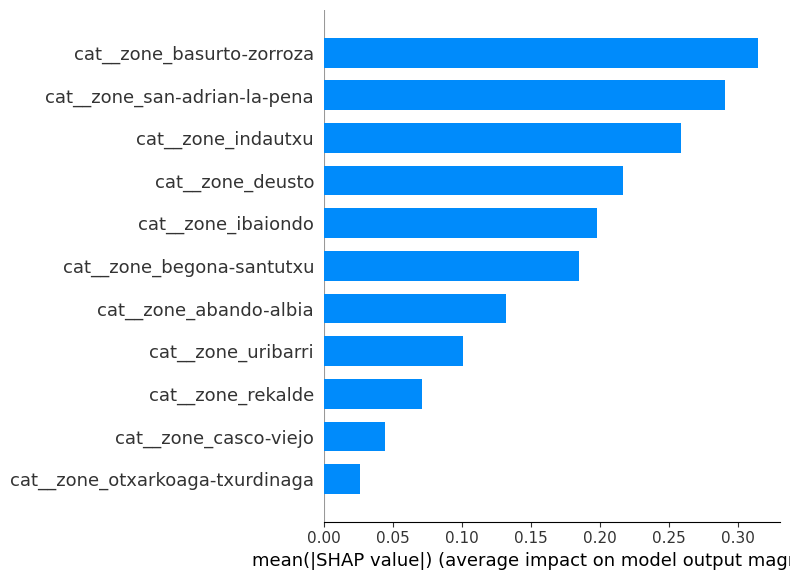

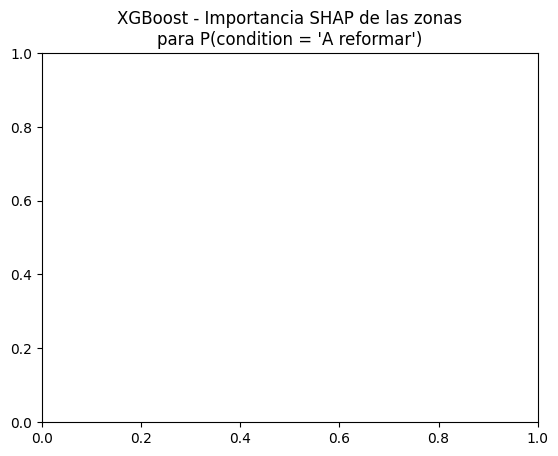

In [ ]:
import numpy as np

# Filtramos solo las columnas que corresponden a 'zone'
zone_mask = np.array(["cat__zone_" in name for name in feature_names_xgb])
zone_features = feature_names_xgb[zone_mask]

shap_xgb_zone = shap_xgb_ar[:, zone_mask]
X_test_xgb_zone = X_test_xgb_sample[:, zone_mask]

shap.summary_plot(
    shap_xgb_zone,
    X_test_xgb_zone,
    feature_names=zone_features,
    plot_type="bar"
)
plt.title("XGBoost - Importancia SHAP de las zonas\npara P(condition = 'A reformar')")
plt.show()


C:\Users\xabier.villa\AppData\Local\Temp\ipykernel_23316\339280870.py:18: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)


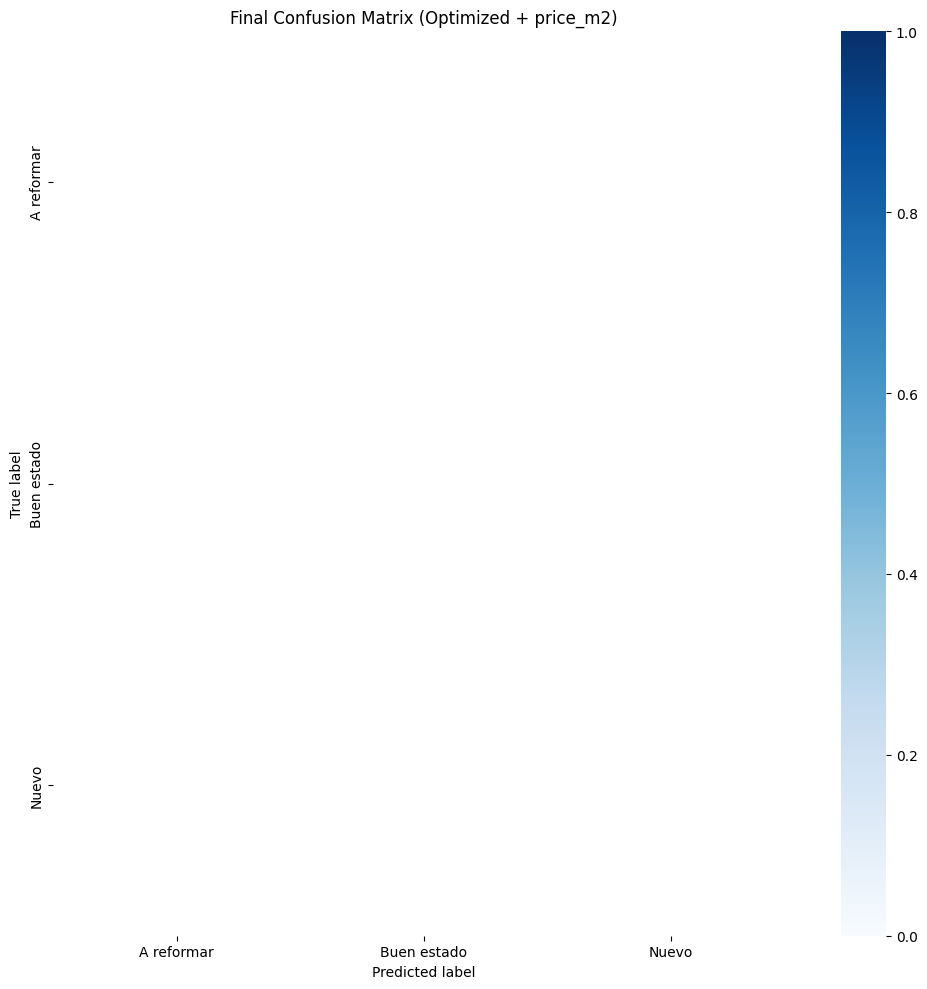

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_normalized_confusion_matrix(model, X_test, y_test,
                                     title="Final Confusion Matrix (Optimized + price_m2)"):
    # Predicciones
    y_pred = model.predict(X_test)

    # Etiquetas en el orden que queramos (aquí, únicas de y_test)
    labels = np.unique(y_test)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    # Normalizamos por filas (recall por clase)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    # Plot
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1
    )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# EJEMPLO:
champion_model = xgb_pipeline   # o xgb_pipeline, etc.
plot_normalized_confusion_matrix(champion_model, X_test, y_test)


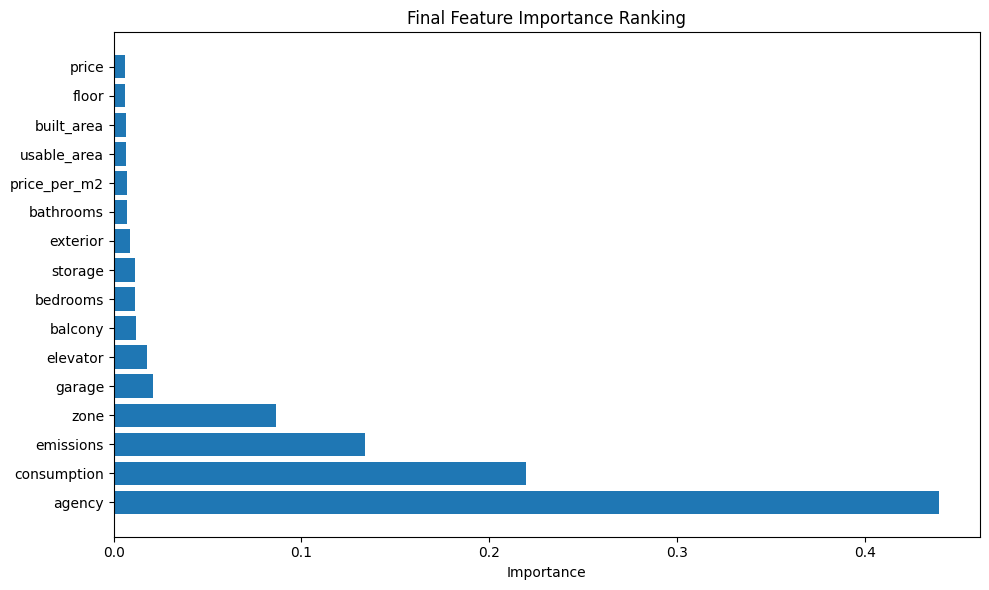


Importancia agregada por variable original:
agency           0.439485
consumption      0.219445
emissions        0.133704
zone             0.086543
garage           0.021008
elevator         0.017537
balcony          0.011960
bedrooms         0.011436
storage          0.011196
exterior         0.008791
bathrooms        0.007128
price_per_m2     0.006840
usable_area      0.006537
built_area       0.006421
floor            0.006161
price            0.005807


In [ ]:
from collections import defaultdict

def plot_feature_importance_aggregated(pipeline, title="Final Feature Importance Ranking"):
    """
    pipeline: Pipeline(sklearn) con steps 'preprocess' (ColumnTransformer)
              y 'clf' (modelo de árboles con feature_importances_).
    """
    preproc = pipeline.named_steps["preprocess"]
    clf = pipeline.named_steps["clf"]

    # Importancias por columna transformada
    feature_names = preproc.get_feature_names_out()
    importances = clf.feature_importances_

    # Agrupamos por VARIABLE original (price, price_m2, zone, agency, ...)
    agg_importance = defaultdict(float)

    for fname, imp in zip(feature_names, importances):
        if fname.startswith("num__"):
            # num__price, num__price_per_m2, num__year...
            orig = fname.split("num__")[1]
        elif fname.startswith("cat__"):
            # cat__zone_basurto-zorroza -> zone
            rest = fname.split("cat__")[1]
            orig = rest.split("_")[0]   # trozo hasta el primer "_"
        else:
            orig = fname

        agg_importance[orig] += imp

    # Ordenamos de más a menos importante
    items = sorted(agg_importance.items(), key=lambda x: x[1], reverse=True)
    features, scores = zip(*items)

    # Plot
    plt.figure(figsize=(10, 6))
    idxs = np.arange(len(features))[::-1]  # para que la más importante quede arriba
    plt.barh(idxs, np.array(scores)[::-1])
    plt.yticks(idxs, features[::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # Por si quieres imprimir los valores numéricos
    print("\nImportancia agregada por variable original:")
    for f, s in items:
        print(f"{f:15s}  {s:.6f}")

# EJEMPLO DE USO (cambia 'zone_model' por tu modelo final: xgb_pipeline, voting_clf, etc.)
plot_feature_importance_aggregated(xgb_pipeline ,title="Final Feature Importance Ranking")
